# CAI - Colony Avalanche Ecosystem Index

Crypto index tracking is a popular passive investment strategy. Since an index cannot be traded directly, index tracking refers to the process of creating a set of crypto assets managed by smart contract that approximates its performance. A straightforward way to do that is to purchase all the assets that compose an index in appropriate quantities.

In order to compensate for the price changes of the individual assets in the index we need to rebalance the portfolio. Choosing the optimal frequency is not an easy task and many factors (e.g., transaction costs, volatility, type of assets, etc.) need to be taken into account.

Conventional approaches to index portfolio rebalancing include periodic and tolerance band rebalancing. With periodic rebalancing, the portfolio is adjusted from its current weights back to the target weights at a consistent time interval (e.g., monthly or quarterly).

## Setting

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

In [4]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion cretira

1. **Project and token characteristics**
    1.     The project’s token should have been listed on CoinGecko with pricing data at least 6 months prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Avalanche. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.

1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have at least $2mm of onchain liquidity on a single pair.
    1. The token must have shown consistent DeFi liquidity on Avalanche.

1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available.



### Tokens list

In [5]:
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [6]:
coins_list = pd.DataFrame(cg.get_coins_list(include_platform=True, order='market_cap_desc'))


In [7]:
tokens = {}
tokens_by_addr = {}
for index, coin in coins_list.iterrows():
    if len(coin['platforms']) >= 1 and 'avalanche' == list(coin['platforms'].keys())[0]:
        symbol = ''.join(c for c in coin['symbol'] if c.isalnum()).upper()
        address = coin['platforms']['avalanche'].lower()
        token = {
            'symbol': symbol,
            'address': address 
        }
        tokens[symbol] = token
        tokens_by_addr[address] = token
        

In [8]:
tokens['USDC'], tokens['WAVAX']

({'symbol': 'USDC', 'address': '0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664'},
 {'symbol': 'WAVAX', 'address': '0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7'})

#### Market data

In [9]:
tokens_data = [] 
tokens_data_page = pd.DataFrame(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc'))
tokens_data.append(tokens_data_page)
for i in range(2, 20):
    tokens_data_page = pd.DataFrame(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', page=i))
    tokens_data.append(tokens_data_page)
tokens_data = pd.concat(tokens_data)
tokens_data = tokens_data.set_index(tokens_data['symbol'].str.upper())

In [10]:
tokens_data

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
BTC,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,24249.000000,460732376424,1,5.074633e+11,4.533717e+10,28197.000000,...,2.100000e+07,2.100000e+07,69045.000000,-64.64363,2021-11-10T14:24:11.849Z,67.810000,35900.71178,2013-07-06T00:00:00.000Z,None,2022-06-13T09:12:55.978Z
ETH,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,1209.450000,147270028833,2,NaN,3.239158e+10,1537.930000,...,NaN,NaN,4878.260000,-74.81453,2021-11-10T14:24:19.604Z,0.432979,283658.11700,2015-10-20T00:00:00.000Z,"{'times': 65.68648260877748, 'currency': 'btc'...",2022-06-13T09:12:42.726Z
USDT,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.004000,72345932860,3,NaN,6.669644e+10,1.006000,...,7.229398e+10,NaN,1.320000,-24.22108,2018-07-24T00:00:00.000Z,0.572521,75.12500,2015-03-02T00:00:00.000Z,None,2022-06-13T09:12:31.650Z
USDC,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,1.002000,54208188334,4,NaN,9.479369e+09,1.006000,...,5.410133e+10,NaN,1.170000,-14.18071,2019-05-08T00:40:28.300Z,0.891848,12.84525,2021-05-19T13:14:05.611Z,None,2022-06-13T09:12:58.947Z
BNB,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,222.360000,36359503168,5,3.676920e+10,1.008028e+09,268.040000,...,1.632770e+08,1.651168e+08,686.310000,-67.04628,2021-05-10T07:24:17.097Z,0.039818,567897.60320,2017-10-19T00:00:00.000Z,None,2022-06-13T09:13:08.332Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAN,matrix-ai-network,man,Matrix AI Network,https://assets.coingecko.com/coins/images/2698...,0.006703,993892,1888,NaN,2.337620e+05,0.008943,...,2.500000e+08,NaN,2.080000,-99.67253,2018-05-03T19:11:54.733Z,0.003497,94.39505,2020-10-02T20:28:34.680Z,"{'times': -0.9813805490852149, 'currency': 'us...",2022-06-13T09:13:05.725Z
CHX,chainium,chx,WeOwn,https://assets.coingecko.com/coins/images/1943...,0.006625,989257,1906,NaN,6.106800e+04,0.007931,...,1.689565e+08,NaN,0.341628,-98.01314,2019-02-22T04:23:32.913Z,0.001983,242.27086,2020-11-16T14:36:05.623Z,"{'times': -0.9053630052663978, 'currency': 'us...",2022-06-13T09:13:18.720Z
FILDA,filda,filda,Filda,https://assets.coingecko.com/coins/images/1393...,0.005447,988632,1900,2.716359e+06,1.303835e+04,0.006089,...,5.000000e+08,5.000000e+08,2.360000,-99.76862,2021-02-20T01:00:26.617Z,0.005486,-0.32203,2022-06-13T08:57:27.566Z,None,2022-06-13T09:13:20.936Z


### Liquidity check

In [11]:
dex_subgraph_urls = {
    'Trader Joe': 'https://api.thegraph.com/subgraphs/name/traderjoe-xyz/exchange',
    'Pangolin': 'https://api.thegraph.com/subgraphs/name/dasconnor/pangolin-dex'
} 

In [12]:
query = """
    query pairs ($token0_ids: [ID!]!, $token1_ids: [ID!]!) {
        pairs (first:1000, where: {token0_in: $token0_ids, token1_in: $token1_ids}){
            id
            token0 {
              id
            }
            token1 {
              id
            }
            reserveUSD
        }
    }
    """

In [13]:
base_tokens = [tokens['WAVAX'], tokens['USDC']] 
base_tokens

[{'symbol': 'WAVAX', 'address': '0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7'},
 {'symbol': 'USDC', 'address': '0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664'}]

In [14]:
topn = 10000 
topn_tokens = [tokens[symb] 
               for symb in tokens_data[:topn].index 
               if symb in tokens.keys()]
topn_tokens.extend(base_tokens)

In [15]:
base_tokens_ids = [token['address'] for token in base_tokens]
tokens_ids = [token['address'] for token in topn_tokens] 

In [16]:
rows = {token['symbol']: {} for token in topn_tokens}
for dex_name, url in dex_subgraph_urls.items():
    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': base_tokens_ids, 'token1_ids': tokens_ids}})
    pairs1 = request.json()['data']['pairs']

    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': tokens_ids, 'token1_ids': base_tokens_ids}})
    pairs2 = request.json()['data']['pairs']
    
    pairs = pairs1 + pairs2
    
    print(f"{dex_name}: {len(pairs)} pairs")
    
    for pair in pairs:
        if pair['token0']['id'] in base_tokens_ids:
            base_token = tokens_by_addr[pair['token0']['id']]
            token = tokens_by_addr[pair['token1']['id']]
        else:
            base_token = tokens_by_addr[pair['token1']['id']]
            token = tokens_by_addr[pair['token0']['id']]
        
        colname = f"{dex_name}_{base_token['symbol']}" 
        
        rows[token['symbol']][colname] = float(pair['reserveUSD'])

Trader Joe: 71 pairs
Pangolin: 42 pairs


In [17]:
liquidities = pd.DataFrame.from_dict(rows, orient='index')
liquidities = liquidities.rename(index={'WAVAX': 'AVAX'})
liq_check = (liquidities > 2e6).any(axis=1).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [18]:
liquidities

,Trader Joe_USDC,Trader Joe_WAVAX,Pangolin_USDC,Pangolin_WAVAX
USDT,1.432675e+06,1.184288e+07,2.366360e+05,5.426585e+06
SUSD,1.007826e+04,NaN,9.990253e-07,4.690038e-02
JOE,5.519359e+05,7.326614e+06,3.988422e+00,2.155750e+04
SAVAX,1.729256e-01,5.735841e+06,NaN,4.223473e+05
QI,2.208191e-04,1.344806e+05,NaN,2.806850e+06
TIME,2.291381e-02,7.885741e+04,NaN,1.222326e+04
SB,1.510778e-03,7.051462e+03,NaN,3.967206e+01
FITFI,2.473999e+00,5.354757e+03,NaN,3.420635e+04
THOR,1.099960e+01,2.379447e+06,NaN,9.398410e+00
CREAM,4.493320e-02,9.965048e+03,NaN,NaN


In [19]:
lq_passed = tokens_data[
    tokens_data.index.isin(liq_check_passed.index)
]

In [20]:
lq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
USDT,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.004000,72345932860,3,NaN,6.669644e+10,1.006000,...,7.229398e+10,NaN,1.32000,-24.22108,2018-07-24T00:00:00.000Z,0.572521,75.12500,2015-03-02T00:00:00.000Z,None,2022-06-13T09:12:31.650Z
AVAX,avalanche-2,avax,Avalanche,https://assets.coingecko.com/coins/images/1255...,15.000000,4178682737,18,1.070778e+10,9.632749e+08,19.180000,...,4.050714e+08,7.200000e+08,144.96000,-89.61175,2021-11-21T14:18:56.538Z,2.800000,437.61477,2020-12-31T13:15:21.540Z,None,2022-06-13T09:13:46.058Z
JOE,joe,joe,JOE,https://assets.coingecko.com/coins/images/1756...,0.178521,48893268,378,8.865456e+07,8.648559e+06,0.231384,...,3.721233e+08,5.000000e+08,5.09000,-96.51618,2021-11-21T14:27:00.202Z,0.026588,566.55841,2021-08-11T14:01:35.223Z,None,2022-06-13T09:13:25.708Z
SAVAX,benqi-liquid-staked-avax,savax,BENQI Liquid Staked AVAX,https://assets.coingecko.com/coins/images/2365...,15.250000,46642222,389,NaN,1.049977e+06,19.540000,...,3.064874e+06,NaN,103.55000,-85.16437,2022-04-02T13:44:54.612Z,15.410000,-0.34010,2022-06-13T08:59:21.371Z,None,2022-06-13T09:13:03.275Z
QI,benqi,qi,BENQI,https://assets.coingecko.com/coins/images/1636...,0.019820,43910664,407,1.424538e+08,1.251211e+08,0.022700,...,7.200000e+09,7.200000e+09,0.39417,-94.92456,2021-08-24T03:58:11.390Z,0.008900,124.78300,2022-05-12T07:26:36.407Z,None,2022-06-13T09:13:05.557Z
THOR,thorswap,thor,THORSwap,https://assets.coingecko.com/coins/images/1929...,0.284325,22670052,584,1.409294e+08,1.381510e+05,0.355455,...,5.000000e+08,5.000000e+08,3.05000,-90.66869,2021-11-06T09:21:45.214Z,0.278731,2.18352,2022-02-24T13:33:20.335Z,None,2022-06-13T09:13:41.099Z
QI,qi-dao,qi,Qi Dao,https://assets.coingecko.com/coins/images/1532...,0.104482,7914128,919,2.091598e+07,3.139460e+05,0.161048,...,2.000000e+08,2.000000e+08,6.09000,-98.29322,2021-06-16T09:41:28.898Z,0.104991,-0.93014,2022-06-13T08:53:09.506Z,None,2022-06-13T09:13:20.659Z


### Non quantative checks

In [22]:
exclude_list = [
    {
        'symbol': 'USDT',
        'id': 'tether',
        'reason': 'Stable coin'
    },
    {
        'symbol': 'QI',
        'id': 'qi-dao',
        'reason': 'Duplicate'
    }
]
exclude_ids = [token['id'] for token in exclude_list]

In [23]:
nq_passed = lq_passed[
    ~lq_passed['id'].isin(exclude_ids)
]

In [24]:
nq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
AVAX,avalanche-2,avax,Avalanche,https://assets.coingecko.com/coins/images/1255...,15.000000,4178682737,18,1.070778e+10,963274943.0,19.180000,...,4.050714e+08,7.200000e+08,144.96000,-89.61175,2021-11-21T14:18:56.538Z,2.800000,437.61477,2020-12-31T13:15:21.540Z,None,2022-06-13T09:13:46.058Z
JOE,joe,joe,JOE,https://assets.coingecko.com/coins/images/1756...,0.178521,48893268,378,8.865456e+07,8648559.0,0.231384,...,3.721233e+08,5.000000e+08,5.09000,-96.51618,2021-11-21T14:27:00.202Z,0.026588,566.55841,2021-08-11T14:01:35.223Z,None,2022-06-13T09:13:25.708Z
SAVAX,benqi-liquid-staked-avax,savax,BENQI Liquid Staked AVAX,https://assets.coingecko.com/coins/images/2365...,15.250000,46642222,389,NaN,1049977.0,19.540000,...,3.064874e+06,NaN,103.55000,-85.16437,2022-04-02T13:44:54.612Z,15.410000,-0.34010,2022-06-13T08:59:21.371Z,None,2022-06-13T09:13:03.275Z
QI,benqi,qi,BENQI,https://assets.coingecko.com/coins/images/1636...,0.019820,43910664,407,1.424538e+08,125121084.0,0.022700,...,7.200000e+09,7.200000e+09,0.39417,-94.92456,2021-08-24T03:58:11.390Z,0.008900,124.78300,2022-05-12T07:26:36.407Z,None,2022-06-13T09:13:05.557Z
THOR,thorswap,thor,THORSwap,https://assets.coingecko.com/coins/images/1929...,0.284325,22670052,584,1.409294e+08,138151.0,0.355455,...,5.000000e+08,5.000000e+08,3.05000,-90.66869,2021-11-06T09:21:45.214Z,0.278731,2.18352,2022-02-24T13:33:20.335Z,None,2022-06-13T09:13:41.099Z


### Retrieving marketcaps and prices

In [25]:
min_lifetime = 180
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for index, data in nq_passed[['id', 'symbol']].iterrows():
    id_ = data['id']
    symbol = data['symbol'].upper()
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', symbol])
    df_prices = df_prices[df_prices[symbol] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < min_lifetime:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < {min_lifetime} days')
        exclude_list.append(symbol)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', symbol])
    df_mcaps = df_mcaps[df_mcaps[symbol] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < min_lifetime:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < {min_lifetime} days')
        
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)

Excluding SAVAX, prices data available only for 115 < 180 days


In [26]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [27]:
lt_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
AVAX,avalanche-2,avax,Avalanche,https://assets.coingecko.com/coins/images/1255...,15.000000,4178682737,18,1.070778e+10,963274943.0,19.180000,...,4.050714e+08,7.200000e+08,144.96000,-89.61175,2021-11-21T14:18:56.538Z,2.800000,437.61477,2020-12-31T13:15:21.540Z,None,2022-06-13T09:13:46.058Z
JOE,joe,joe,JOE,https://assets.coingecko.com/coins/images/1756...,0.178521,48893268,378,8.865456e+07,8648559.0,0.231384,...,3.721233e+08,5.000000e+08,5.09000,-96.51618,2021-11-21T14:27:00.202Z,0.026588,566.55841,2021-08-11T14:01:35.223Z,None,2022-06-13T09:13:25.708Z
QI,benqi,qi,BENQI,https://assets.coingecko.com/coins/images/1636...,0.019820,43910664,407,1.424538e+08,125121084.0,0.022700,...,7.200000e+09,7.200000e+09,0.39417,-94.92456,2021-08-24T03:58:11.390Z,0.008900,124.78300,2022-05-12T07:26:36.407Z,None,2022-06-13T09:13:05.557Z
THOR,thorswap,thor,THORSwap,https://assets.coingecko.com/coins/images/1929...,0.284325,22670052,584,1.409294e+08,138151.0,0.355455,...,5.000000e+08,5.000000e+08,3.05000,-90.66869,2021-11-06T09:21:45.214Z,0.278731,2.18352,2022-02-24T13:33:20.335Z,None,2022-06-13T09:13:41.099Z


### Marketcap ranking & top10 filtering

In [28]:
chosen_tokens = lt_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [29]:
chosen_tokens

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
AVAX,avalanche-2,avax,Avalanche,https://assets.coingecko.com/coins/images/1255...,15.000000,4178682737,18,1.070778e+10,963274943.0,19.180000,...,4.050714e+08,7.200000e+08,144.96000,-89.61175,2021-11-21T14:18:56.538Z,2.800000,437.61477,2020-12-31T13:15:21.540Z,None,2022-06-13T09:13:46.058Z
JOE,joe,joe,JOE,https://assets.coingecko.com/coins/images/1756...,0.178521,48893268,378,8.865456e+07,8648559.0,0.231384,...,3.721233e+08,5.000000e+08,5.09000,-96.51618,2021-11-21T14:27:00.202Z,0.026588,566.55841,2021-08-11T14:01:35.223Z,None,2022-06-13T09:13:25.708Z
QI,benqi,qi,BENQI,https://assets.coingecko.com/coins/images/1636...,0.019820,43910664,407,1.424538e+08,125121084.0,0.022700,...,7.200000e+09,7.200000e+09,0.39417,-94.92456,2021-08-24T03:58:11.390Z,0.008900,124.78300,2022-05-12T07:26:36.407Z,None,2022-06-13T09:13:05.557Z
THOR,thorswap,thor,THORSwap,https://assets.coingecko.com/coins/images/1929...,0.284325,22670052,584,1.409294e+08,138151.0,0.355455,...,5.000000e+08,5.000000e+08,3.05000,-90.66869,2021-11-06T09:21:45.214Z,0.278731,2.18352,2022-02-24T13:33:20.335Z,None,2022-06-13T09:13:41.099Z


In [30]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [31]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [32]:
prices_data

,AVAX,JOE,QI,THOR
date,,,,
2021-11-26,118.878941,3.706802,0.262849,1.799558
2021-11-27,104.421963,2.677786,0.218421,1.670518
2021-11-28,111.984348,3.000227,0.213764,1.802632
2021-11-29,110.973521,3.156193,0.222700,1.843367
2021-11-30,118.610406,3.273089,0.244574,1.773940
...,...,...,...,...
2022-06-09,24.504974,0.288982,0.014833,0.410683
2022-06-10,24.393303,0.287250,0.014326,0.401808
2022-06-11,22.124894,0.255646,0.013436,0.370961


In [33]:
marketcaps

,AVAX,JOE,QI,THOR
date,,,,
2021-11-26,2.660528e+10,4.613322e+08,2.490583e+08,4.560447e+07
2021-11-27,2.334469e+10,3.323495e+08,2.065181e+08,4.239909e+07
2021-11-28,2.492920e+10,3.745332e+08,2.021817e+08,4.592035e+07
2021-11-29,2.492308e+10,3.955928e+08,2.104229e+08,4.687656e+07
2021-11-30,2.638898e+10,4.157301e+08,2.315167e+08,4.590617e+07
...,...,...,...,...
2022-06-09,6.900732e+09,7.986736e+07,3.278698e+07,3.294771e+07
2022-06-10,6.848118e+09,7.903975e+07,3.172253e+07,3.210844e+07
2022-06-11,6.222586e+09,7.038219e+07,2.978301e+07,2.975181e+07


### Assets data

In [34]:
tickers = list(prices_data.columns)

In [35]:
prices_data / prices_data.iloc[0] - 1

,AVAX,JOE,QI,THOR
date,,,,
2021-11-26,0.000000,0.000000,0.000000,0.000000
2021-11-27,-0.121611,-0.277602,-0.169025,-0.071707
2021-11-28,-0.057997,-0.190616,-0.186742,0.001708
2021-11-29,-0.066500,-0.148540,-0.152742,0.024344
2021-11-30,-0.002259,-0.117004,-0.069525,-0.014236
...,...,...,...,...
2022-06-09,-0.793866,-0.922040,-0.943569,-0.771787
2022-06-10,-0.794806,-0.922507,-0.945497,-0.776718
2022-06-11,-0.813887,-0.931033,-0.948882,-0.793860


/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



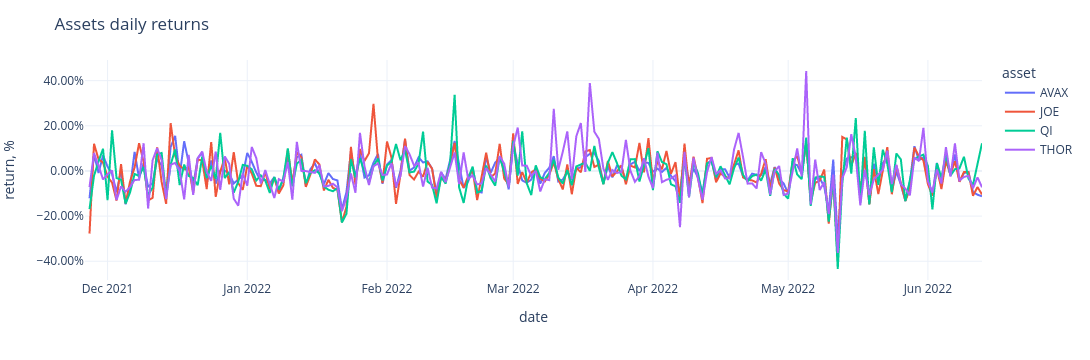

In [36]:
fig = px.line(prices_data.pct_change(),
       labels={'variable': 'asset', 'value': 'return, %'})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    template='plotly_white',
    title='Assets daily returns'
)
fig.show()

## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 50%.
* All excess weight is proportionally redistributed to all uncapped tokens.
* Any asset with a weight below 0.5% will be removed from the index.

### Iterative proportional adjusting

In [37]:
def adjust_weights(w, b):
    assert abs(w.sum() - 1) < 0.01, w.sum()
    assert b * w.shape[0] >=1
    wa = w.copy()
    
    while (wa > b).any():
        c = (wa[wa>b]-b).sum()
        wa[wa > b] = b
        w_less = wa[wa < b]
        wa[wa < b] += c * (w_less / w_less.sum())
    
    return wa

### Weight mcaps

In [38]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

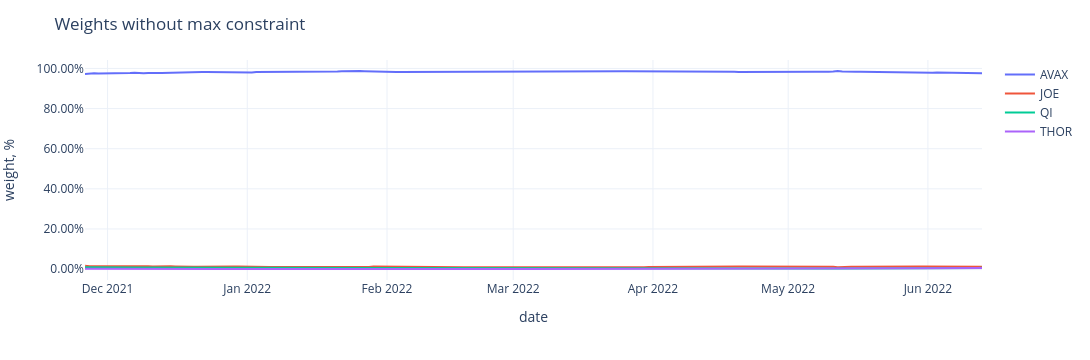

In [39]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

In [40]:
weights

,AVAX,JOE,QI,THOR
date,,,,
2021-11-26,0.972370,0.016861,0.009103,0.001667
2021-11-27,0.975706,0.013891,0.008632,0.001772
2021-11-28,0.975632,0.014658,0.007913,0.001797
2021-11-29,0.974472,0.015467,0.008227,0.001833
2021-11-30,0.974406,0.015351,0.008549,0.001695
...,...,...,...,...
2022-06-09,0.979336,0.011335,0.004653,0.004676
2022-06-10,0.979564,0.011306,0.004538,0.004593
2022-06-11,0.979549,0.011079,0.004688,0.004683


### Adjust weights

In [41]:
adjusted_weights = weights.apply(adjust_weights, args=[0.5], axis=1)
adjusted_weights = adjusted_weights.loc[:, adjusted_weights.iloc[-1] > 0.005]

/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



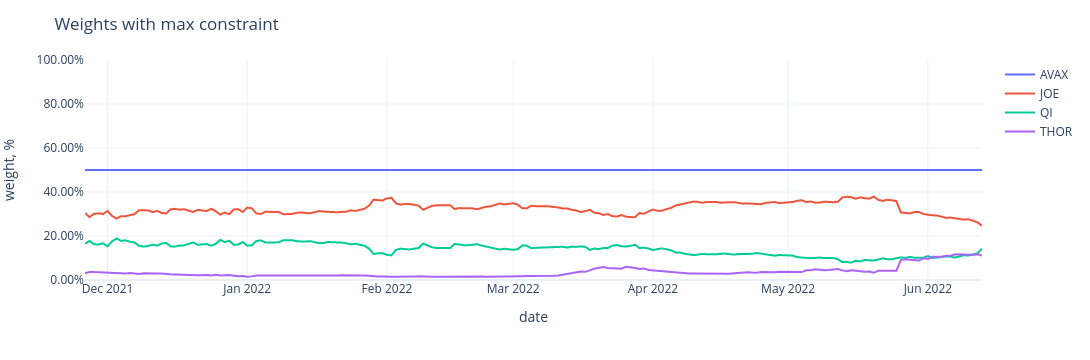

In [42]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
    range=[0, 1],
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

In [43]:
adjusted_weights

,AVAX,JOE,QI,THOR
date,,,,
2021-11-26,0.5,0.305116,0.164722,0.030162
2021-11-27,0.5,0.285884,0.177645,0.036471
2021-11-28,0.5,0.300765,0.162360,0.036876
2021-11-29,0.5,0.302954,0.161147,0.035899
2021-11-30,0.5,0.299883,0.167003,0.033114
...,...,...,...,...
2022-06-09,0.5,0.274266,0.112591,0.113143
2022-06-10,0.5,0.276613,0.111018,0.112369
2022-06-11,0.5,0.270874,0.114623,0.114503


### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [44]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)
    
    remainders = w_scaled - w_res
    
    k = round(remainders.sum())
    k_largest_rems = np.argsort(remainders)[::-1][:k]
    
    w_res[k_largest_rems] += 1
    
    return w_res 

In [45]:
last_weights = adjusted_weights.iloc[-1]
last_weights

AVAX    0.500000
JOE     0.245935
QI      0.142307
THOR    0.111758
Name: 2022-06-13 00:00:00, dtype: float64

In [46]:
converted_last_weights = convert_weights(last_weights)
converted_last_weights

AVAX    128
JOE      63
QI       36
THOR     28
Name: 2022-06-13 00:00:00, dtype: int64

## Summary table

In [47]:
cai = pd.DataFrame()
cai.index = chosen_tokens.index
cai['name'] = chosen_tokens['name']
cai['market_cap'] = marketcaps.iloc[-1].astype(int)
cai['price'] = prices_data.iloc[-1]
cai['weight'] = last_weights
cai['weight_converted'] = converted_last_weights
cai['address'] = [tokens[symb]['address'] for symb in cai.index]

In [48]:
cai

,name,market_cap,price,weight,weight_converted,address
symbol,,,,,,
AVAX,Avalanche,4968584616,17.574085,0.500000,128,fvweahmxkfeig8snevq42hc6whryy3efyavebmqdndgcgxn5z
JOE,JOE,59521180,0.212586,0.245935,63,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
QI,BENQI,34441077,0.015452,0.142307,36,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5
THOR,THORSwap,27047751,0.334415,0.111758,28,0x8f47416cae600bccf9530e9f3aeaa06bdd1caa79
